<a href="https://colab.research.google.com/github/Whoami666/HSE_Lab/blob/main/clean_models/schiz_models_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 4.0 MB/s eta 0:00:00


In [2]:
%cd drive
%cd MyDrive
%cd shiz

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/shiz


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [4]:
df = pd.read_excel('df_standard_cleaned_21feb.xlsx') 
df1d = pd.read_excel('df_standard_only1dfeatures.xlsx')

df = df.set_index('ID')
df1d = df1d.set_index('ID')
df.head(1)

,sex,tds,chroma_cens_avg,chroma_cens_std,chroma_cqt_avg,chroma_cqt_std,chroma_stft_avg,chroma_stft_std,melspectrogram_avg,melspectrogram_std,...,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std,tds_binary
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,0,0.685706,0.428088,0.425039,0.296394,0.339246,0.434412,0.327867,0.348849,...,0.31499,0.397736,0.254215,0.747885,0.719312,0.691479,0.329593,0.197304,0.281692,0


Models

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.svm import SVC

**Non-binary**

All features

In [40]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [41]:
warnings.filterwarnings('ignore')
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.9111705288175876
test score: 0.8529411764705882


In [42]:
params = opt.best_params_
svm = SVC(gamma=params['gamma'], degree=params['degree'], C=params['C'], kernel=params['kernel'])
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        60
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2

    accuracy                           0.85        68
   macro avg       0.29      0.32      0.31        68
weighted avg       0.78      0.85      0.81        68



In [43]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(svm, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(svm, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.8411764705882353 ± 0.20043205926353905
recall 0.5907650560224089 ± 0.2741142672492425


Only1D

In [15]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [16]:
warnings.filterwarnings('ignore')
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.8912655971479501
test score: 0.8823529411764706


In [20]:
params = opt.best_params_
svm = SVC(gamma=params['gamma'], degree=params['degree'], C=params['C'], kernel=params['kernel'])
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2

    accuracy                           0.88        68
   macro avg       0.29      0.33      0.31        68
weighted avg       0.78      0.88      0.83        68



In [18]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(svm, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(svm, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.8882352941176471 ± 0.19939354419621522
recall 0.7666666666666666 ± 0.2905932629027116


**Binary**

All features

In [35]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds_binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [36]:
warnings.filterwarnings('ignore')
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.8912655971479501
test score: 0.8823529411764706


In [37]:
params = opt.best_params_
svm = SVC(gamma=params['gamma'], degree=params['degree'], C=params['C'], kernel=params['kernel'])
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.00      0.00      0.00         8

    accuracy                           0.88        68
   macro avg       0.44      0.50      0.47        68
weighted avg       0.78      0.88      0.83        68



In [38]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(svm, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(svm, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.8882352941176471 ± 0.19939354419621522
recall 0.8 ± 0.24494897427831783


In [39]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   svm.coef_.T,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

AttributeError: ignored

Only 1d-features

In [25]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds_binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [26]:
warnings.filterwarnings('ignore')
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.8912655971479501
test score: 0.8823529411764706


In [27]:
params = opt.best_params_
svm = SVC(gamma=params['gamma'], degree=params['degree'], C=params['C'], kernel=params['kernel'])
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.00      0.00      0.00         8

    accuracy                           0.88        68
   macro avg       0.44      0.50      0.47        68
weighted avg       0.78      0.88      0.83        68



In [28]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(svm, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(svm, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.8882352941176471 ± 0.19939354419621522
recall 0.8 ± 0.24494897427831783


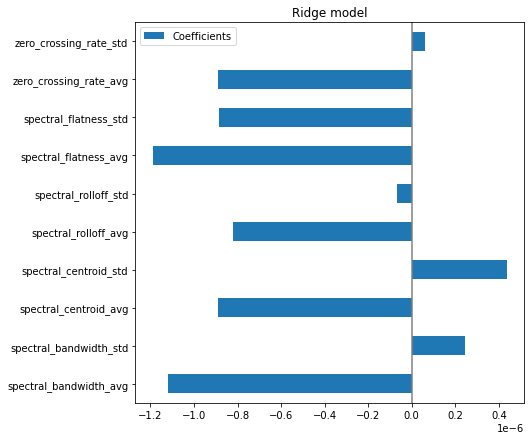

In [29]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   svm.coef_.T,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)